In [2]:
import heapq

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numba import njit
from numba.typed import List
import numpy as np
import seaborn as sns
from tqdm import tqdm

import target_io
import make_clean_showers as mcs
from apply_gains import apply_gains

sns.set_style("whitegrid")

In [2]:
runs = [328629, 328630, 328631]
mod_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 103, 106, 107,
            108, 111, 112, 114, 115, 119, 121, 123, 124, 125, 126]
mod_nums = [100, 111, 114, 107, 6, 115, 123, 124, 112, 7, 119,
            108, 110, 121, 8, 103, 125, 126, 106, 9, 4, 5, 1, 3, 2]
fpm_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24]
fpm_pos = np.mgrid[0:5, 0:5]
fpm_pos = zip(fpm_pos[0].flatten(), fpm_pos[1].flatten())
mod_to_fpm = dict(zip(mod_nums, fpm_nums))
fpm_to_pos = dict(zip(fpm_nums, fpm_pos))
ch_nums = np.array([[21, 20, 17, 16, 5, 4, 1, 0],
                    [23, 22, 19, 18, 7, 6, 3, 2],
                    [29, 28, 25, 24, 13, 12, 9, 8],
                    [31, 30, 27, 26, 15, 14, 11, 10],
                    [53, 52, 49, 48, 37, 36, 33, 32],
                    [55, 54, 51, 50, 39, 38, 35, 34],
                    [61, 60, 57, 56, 45, 44, 41, 40],
                    [63, 62, 59, 58, 47, 46, 43, 42]])
rot_ch_nums = np.rot90(ch_nums, k=2)
ch_to_pos = dict(zip(ch_nums.reshape(-1), np.arange(64)))
rot_ch_to_pos = dict(zip(rot_ch_nums.reshape(-1), np.arange(64)))
num_columns = 5
total_cells = num_columns * num_columns * 64
indices = np.arange(total_cells).reshape(-1, int(np.sqrt(total_cells)))
grid_ind = List()
for index, mod in enumerate(mod_list):
    i, j = fpm_to_pos[mod_to_fpm[mod]]
    ch_map = dict()
    if j % 2 == 0:
        ch_map = rot_ch_to_pos
    else:
        ch_map = ch_to_pos
    # print(f"Channel Map: {ch_map}")
    j = num_columns - 1 - j
    pix_ind = np.array(indices[
        (8*i):8*(i+1), (8*j):8*(j+1)]).reshape(-1)
    # print(f"Pixel Index: {pix_ind}")
    for asic in range(4):
        for ch in range(16):
            grid_ind.append(int(pix_ind[
                ch_map[asic * 16 + ch]]))

In [3]:
noise = np.load("noise.npz")["arr_0"]
reader = target_io.WaveformArrayReader("/data/wipac/CTA/target5and7data/runs_320000_through_329999/cal328555.r1")
n_pixels = reader.fNPixels
n_samples = reader.fNSamples
waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
charge_data = []
for ev in tqdm(noise):
    ev = int(ev)
    reader.GetR1Event(ev, waveforms)
    waveforms = apply_gains(waveforms)
    peak_position = np.argmax(waveforms, axis=1)
    charge = mcs.calculate_charge(waveforms, peak_position, n_samples)
    charge_data.append(charge)
charge_data = np.asarray(charge_data)
pixel_charge = charge_data.T
noise_averages = np.mean(pixel_charge, axis=1)
np.save(noise_averages, "noise_averages")

100%|██████████| 199236/199236 [30:36<00:00, 108.47it/s]


TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

In [5]:
np.savez("noise_averages", noise_averages)

In [20]:
@njit
def clean_image(raw_charge: np.ndarray, grid_ind: List, mean_noise: np.ndarray) -> np.ndarray:
    # constant values relating to the proportion of a square covered
    # by part of a circle
    a = 0.2138
    b = 0.479
    c = 0.985

    # corresponds to an aperture with 2 pxl radius
    aperture = [[0., a, b, a, 0.],
                [a, c, 1., c, a],
                [b, 1., 1., 1., b],
                [a, c, 1., c, a],
                [0., a, b, a, 0.]]
    aperture = np.asarray(aperture)
    charge_temp = np.zeros((40, 40))
    raw_charge_copy = raw_charge
    raw_charge_copy[688:704] = 0.0
    raw_charge_copy[192:256] = 0.0
    raw_charge_copy[0:64] = 0.0
    raw_charge_copy[512:576] = 0.0
    for i, val in enumerate(raw_charge_copy):
        charge_temp[grid_ind[i]//40, grid_ind[i]%40] = val
    
    noise_temp = np.zeros((40, 40))
    for i, val in enumerate(mean_noise):
        noise_temp[grid_ind[i]//40, grid_ind[i]%40] = val

    # charge = np.pad(charge, (2,), constant_values=(0,)
    charge = np.zeros((44, 44))
    charge[2:42, 2:42] = charge_temp
    
    noise_pad = np.zeros((44, 44))
    noise_pad[2:42, 2:42] = noise_temp

    image = np.zeros((40, 40))
    for i in range(40):
        for j in range(40):
            if charge[i+2, j+2] == 0.0:
                image[i, j] = np.NaN
                continue
            s = np.nansum(charge[i:i+5, j:j+5] * aperture)
            noise = np.nansum(noise_pad[i:i+5, j:j+5] * aperture)
            #if s / mean_noise[j, i] > 50:
            if s > noise*2:
                image[i, j] = charge[i+2, j+2]

    return image

In [21]:
def get_frac3(size, image):
    bright3 = np.sum(heapq.nlargest(2, image.flatten()))
    return bright3 / size

In [22]:
@njit
def hillas(charge_coords):
    """Calculates the Hillas parameters for an event."""
    x = 0
    y = 0
    x2 = 0
    y2 = 0
    xy = 0
    CHARGE = 0
    CHARGE = np.nansum(charge_coords[2])
    if CHARGE == 0.0:
        CHARGE = 1.0
    x = np.nansum(charge_coords[0] * charge_coords[2])
    y = np.nansum(charge_coords[1] * charge_coords[2])
    x2 = np.nansum(charge_coords[0] ** 2 * charge_coords[2])
    y2 = np.nansum(charge_coords[1] ** 2 * charge_coords[2])
    xy = np.nansum(charge_coords[0] * charge_coords[1] * charge_coords[2])

    x /= CHARGE
    y /= CHARGE
    x2 /= CHARGE
    y2 /= CHARGE
    xy /= CHARGE

    S2_x = x2 - x ** 2
    S2_y = y2 - y ** 2
    S_xy = xy - x * y
    d = S2_y - S2_x
    a = (d + np.sqrt(d ** 2 + 4 * S_xy ** 2)) / (2 * S_xy)
    b = y - a * x
    width = np.sqrt((S2_y + a ** 2 * S2_x - 2 * a * S_xy) / (1 + a ** 2))
    length = np.sqrt((S2_x + a ** 2 * S2_y + 2 * a * S_xy) / (1 + a ** 2))
    miss = np.abs(b / np.sqrt(1 + a ** 2))
    dis = np.sqrt(x ** 2 + y ** 2)

    q_coord = (x - charge_coords[0]) * (x / dis) + (y - charge_coords[1]) * (y / dis)
    q = np.nansum(q_coord * charge_coords[2]) / CHARGE
    q2 = np.nansum(q_coord ** 2 * charge_coords[2]) / CHARGE
    azwidth = q2 - q ** 2
    alpha = np.arcsin(miss / dis)
    return [a, b, x, y, width, length, miss, dis, azwidth, alpha]

In [23]:
datadir = "/data/wipac/CTA/target5and7data/runs_320000_through_329999"
evdir = "/home/bmode/analysis"
noise_averages = np.load("noise_averages.npz")["arr_0"]
failed_events = []
crab = SkyCoord.from_name("crab")
psct_loc = EarthLocation(lat=31.6716989799*u.deg, lon=-110.951291195*u.deg, height=1268*u.m)

def linear(x, a, b):
    return(a*x + b)

a_x, b_x = (-0.014436381477488698, 1.093377089794729)
a_y_1, b_y_1 = (-0.03798099601727016, 0.36721872391895594) # az < 180 deg
a_y_2, b_y_2 = (-0.11408711008257931, 7.51779699821602) # az > 180 deg

for run in runs:
    calfile = f"{datadir}/cal{run}.r1"
    cosray_file = f"{evdir}/{run}_cosrays.dat"
    gammas_file = f"{evdir}/{run}_gammas.dat"
    cos_evs = np.loadtxt(cosray_file)
    gamma_evs = np.loadtxt(gammas_file)
    reader = target_io.WaveformArrayReader(calfile)
    n_pixels = reader.fNPixels
    n_samples = reader.fNSamples
    waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
    cosray_data_file = f"{run}_cosrays_hillas_v2.csv"
    gamma_data_file = f"{run}_gammas_hillas_v2.csv"
    with open(cosray_data_file, "w") as f:
        div_by_zero = []
        f.write("Event, TACK, CPU_s, Charge_Max, Charge_Mean, Charge_STD, Az, El, Size, Frac3, A, B, X, Y, Width, Length, Miss, Dis, Azwidth, Alpha\n")
        for i, ev in tqdm(enumerate(cos_evs)):
            #try:
            ev = int(ev)
            if run == 328631 and ev > 122804:
                continue
            reader.GetR1Event(ev, waveforms)
            tack = reader.fTACK_time
            if i % 100 == 0:
                reader.GetTimeStamp(ev)
                cpu_s = reader.fCPU_s
                time = Time(cpu_s, format="unix")
                crab_azel = crab.transform_to(AltAz(obstime=time, location=psct_loc))
                az, el = (crab_azel.az.deg, crab_azel.alt.deg)
                delta_x = linear(az, a_x, b_x)
                delta_y = linear(el, a_y_1, b_y_1) if az < 180 else linear(el, a_y_2, b_y_2)
            peak_positions = np.argmax(waveforms, axis=1)
            charges = mcs.calculate_charge(waveforms, peak_positions, n_samples)
            no_charge = [val for val in charges if val == 0.0]
            if len(no_charge) > 750:
                continue
            charges = apply_gains(charges)
            charge_max = np.amax(charges)
            charge_mean = np.mean(charges)
            charge_std = np.std(charges, ddof=1)
            image = clean_image(charges, grid_ind, noise_averages)
            image_size = [val for row in image for val in row  if val > 1.e-4]
            size = np.sum(image_size)
            if size == 0.0:
                continue
            frac3 = get_frac3(size, image)
            #charge_coords = [[i - 19.5 + 0.42 * ((i // 8) - 2), 
            #j - 19.5 + 0.32 * ((j // 8) - 2),
            charge_coords = [[i - 19.5 + 0.31 * ((i // 8) - 2) + delta_x,
                              j - 19.5 + 0.31 * ((j // 8) - 2) + delta_y,
                              image[j, i]]
                              for i in range(40) for j in range(40)]
            try:
                a, b, x, y, width, length, miss, dis, azwidth, alpha = hillas(np.asarray(charge_coords).T)
                f.write(f"{ev}, {tack}, {cpu_s}, {charge_max}, {charge_mean}, {charge_std}, {az}, {el}, {size}, {frac3}, {a}, {b}, {x}, {y}, {width}, {length}, {miss}, {dis}, {azwidth}, {alpha}\n")
            except:
                failed_events.append((run, ev))
                
            #except Exception as ex:
            #    div_by_zero.append(ev)
            #    pass
        #print(len(div_by_zero))
    with open(gamma_data_file, "w") as f:
        f.write("Event, TACK, CPU_s, Charge_Max, Charge_Mean, Charge_STD, Az, El, Size, Frac3, A, B, X, Y, Width, Length, Miss, Dis, Azwidth, Alpha\n")
        div_by_zero = []
        for ev in tqdm(gamma_evs):
            #try:
            ev = int(ev)
            if run == 328631 and ev > 122804:
                continue
            reader.GetR1Event(ev, waveforms)
            tack = reader.fTACK_time
            reader.GetTimeStamp(ev)
            cpu_s = reader.fCPU_s
            time = Time(cpu_s, format="unix")
            crab_azel = crab.transform_to(AltAz(obstime=time, location=psct_loc))
            az, el = (crab_azel.az.deg, crab_azel.alt.deg)
            delta_x = linear(az, a_x, b_x)
            delta_y = linear(el, a_y_1, b_y_1) if az < 180 else linear(el, a_y_2, b_y_2)
            peak_positions = np.argmax(waveforms, axis=1)
            charges = mcs.calculate_charge(waveforms, peak_positions, n_samples)
            charges = apply_gains(charges)
            charge_max = np.amax(charges)
            charge_mean = np.mean(charges)
            charge_std = np.std(charges, ddof=1)
            image = clean_image(charges, grid_ind, noise_averages)
            image_size = [val for row in image for val in row  if val > 1.e-4]
            size = np.sum(image_size)
            if size == 0.0:
                continue
            frac3 = get_frac3(size, image)
            charge_coords = [[i - 19.5 + 0.31 * ((i // 8) - 2) + delta_x, 
                              j - 19.5 + 0.31 * ((j // 8) - 2) + delta_y,
                              image[j, i]]
                              for i in range(40) for j in range(40)]
            try:
                a, b, x, y, width, length, miss, dis, azwidth, alpha = hillas(np.asarray(charge_coords).T)
                f.write(f"{ev}, {tack}, {cpu_s}, {charge_max}, {charge_mean}, {charge_std}, {az}, {el}, {size}, {frac3}, {a}, {b}, {x}, {y}, {width}, {length}, {miss}, {dis}, {azwidth}, {alpha}\n")
            except:
                failed_events.append((run, ev))
            #except Exception as ex:
            #    div_by_zero.append(ev)
            #    pass
        #print(len(div_by_zero))
            

4690it [05:39, 13.80it/s]
100%|██████████| 6/6 [00:00<00:00,  9.89it/s]
4261it [04:57, 14.31it/s]
100%|██████████| 8/8 [00:00<00:00, 12.18it/s]
5244it [02:43, 32.08it/s]
100%|██████████| 5/5 [00:00<00:00, 15.55it/s]


In [13]:
%matplotlib inline
def camera_image(image, run, ev, keep=False):
    maxZ = np.nanmax(image)
    fig = plt.gcf()
    if fig.get_size_inches().all() == np.array([18., 15.]).all():
        plt.close(fig)
        fig = plt.figure(figsize=(18, 15))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.04, hspace=0.04)

    for i in range(5):
        for j in range(5):
            sub_image = image[i*8:i*8+8, j*8:j*8+8]
            ax = plt.subplot(gs[4 - i, j])
            c = ax.pcolormesh(sub_image, vmin=0, vmax=maxZ, cmap="viridis")
            ax.axis("off")
            ax.set_aspect("equal")

    fig.subplots_adjust(right=0.8, top=0.9, bottom=0.1)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(c, cax=cbar_ax)
    cbar.set_label("Charge (Photoelectrons)", rotation=270,
                   size=24, labelpad=24)
    cbar_ax.tick_params(labelsize=20)
    fig.suptitle(f"Run {run} Event {ev}", fontsize=30)
    if keep is True:
        fig.savefig(f"/data/wipac/CTA/web/Users/bmode/cta/coincident_images/run{run}_ev{ev}_cleaned_image.png")

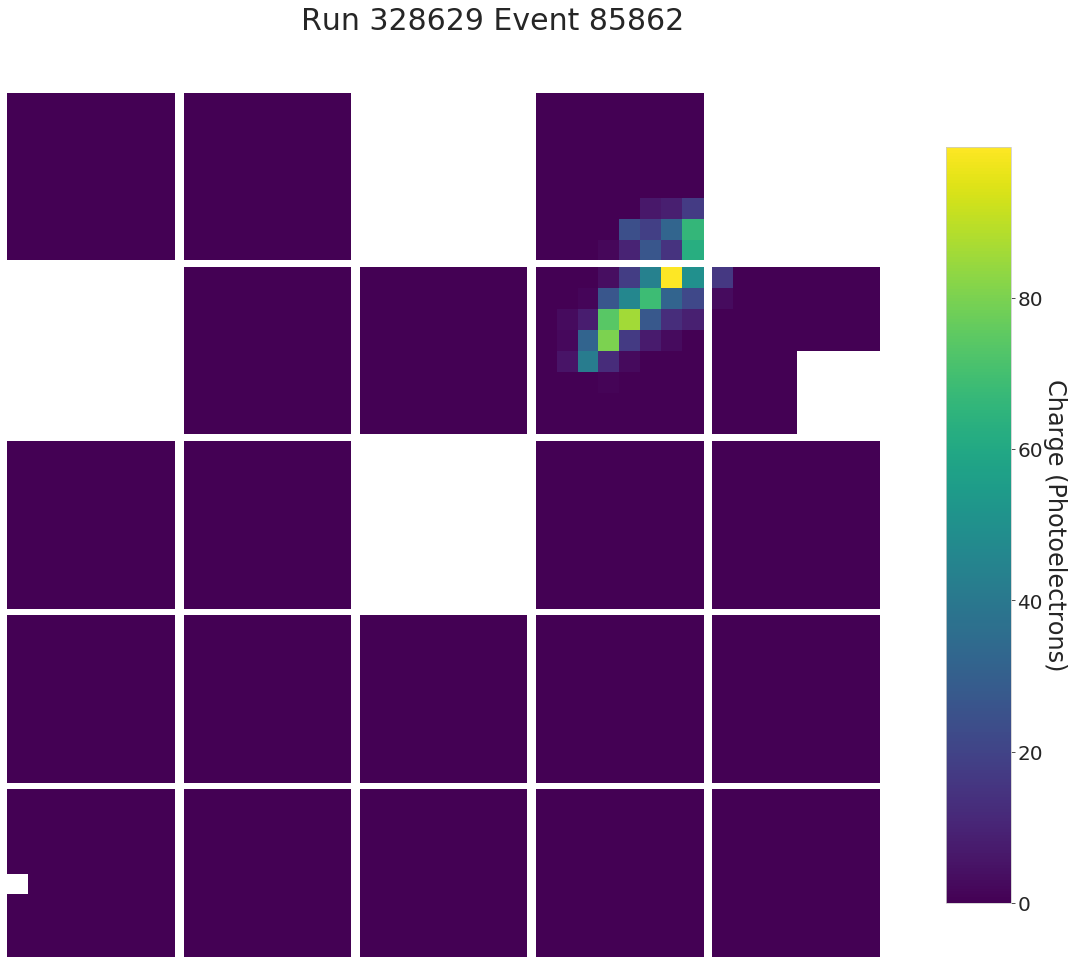

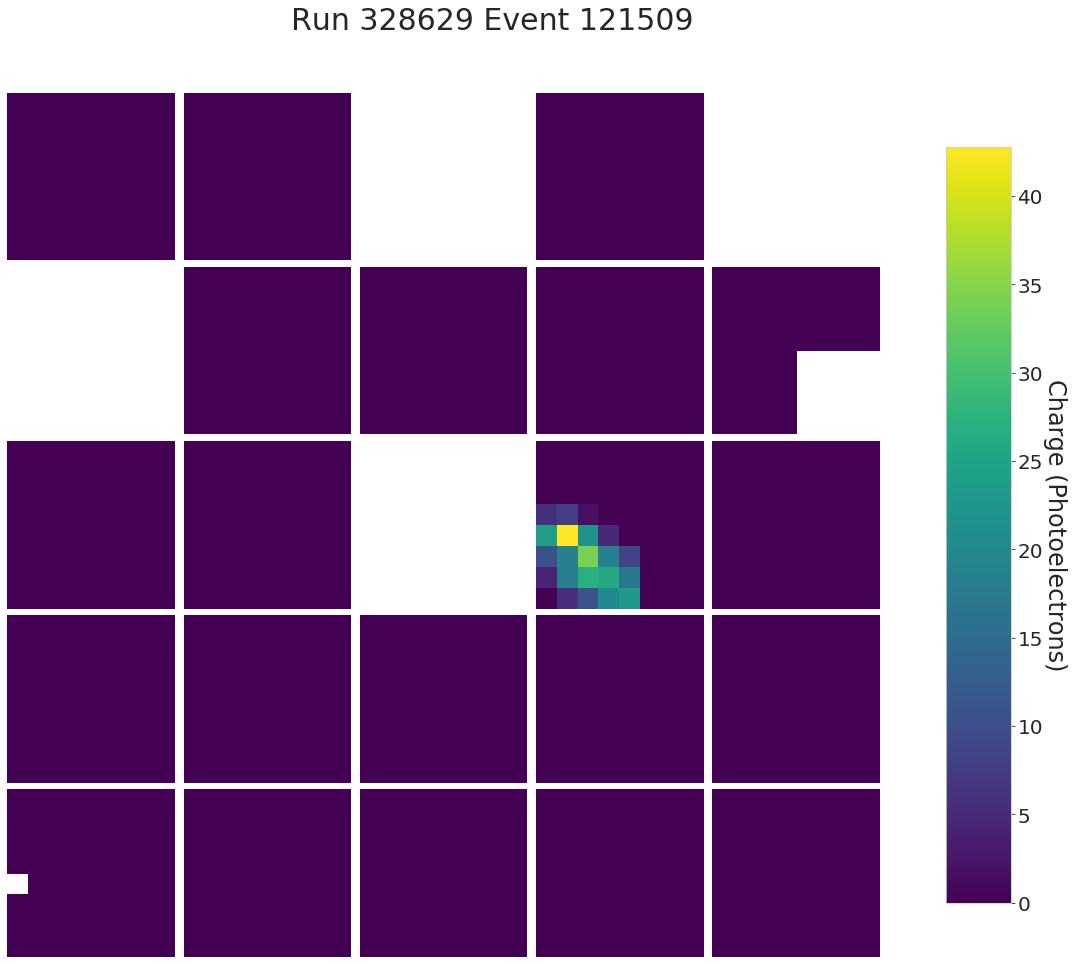

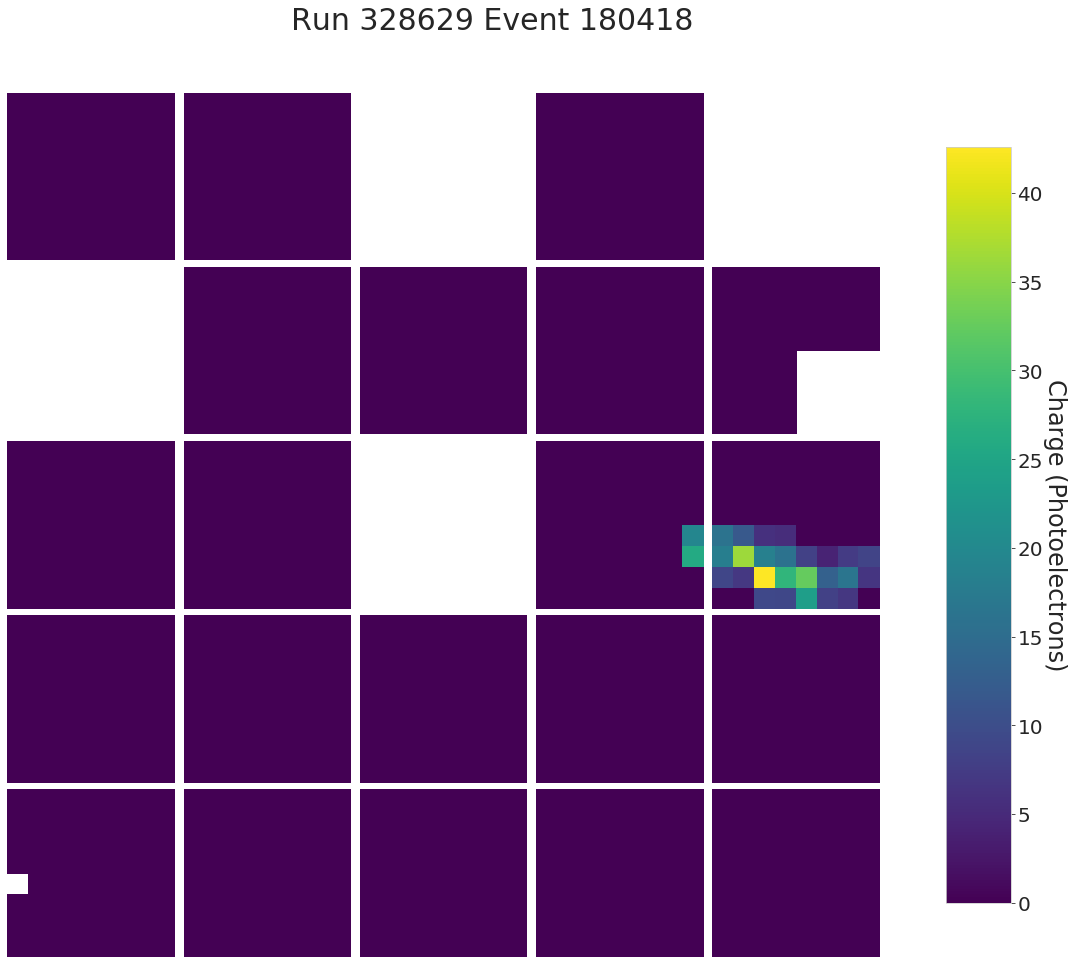

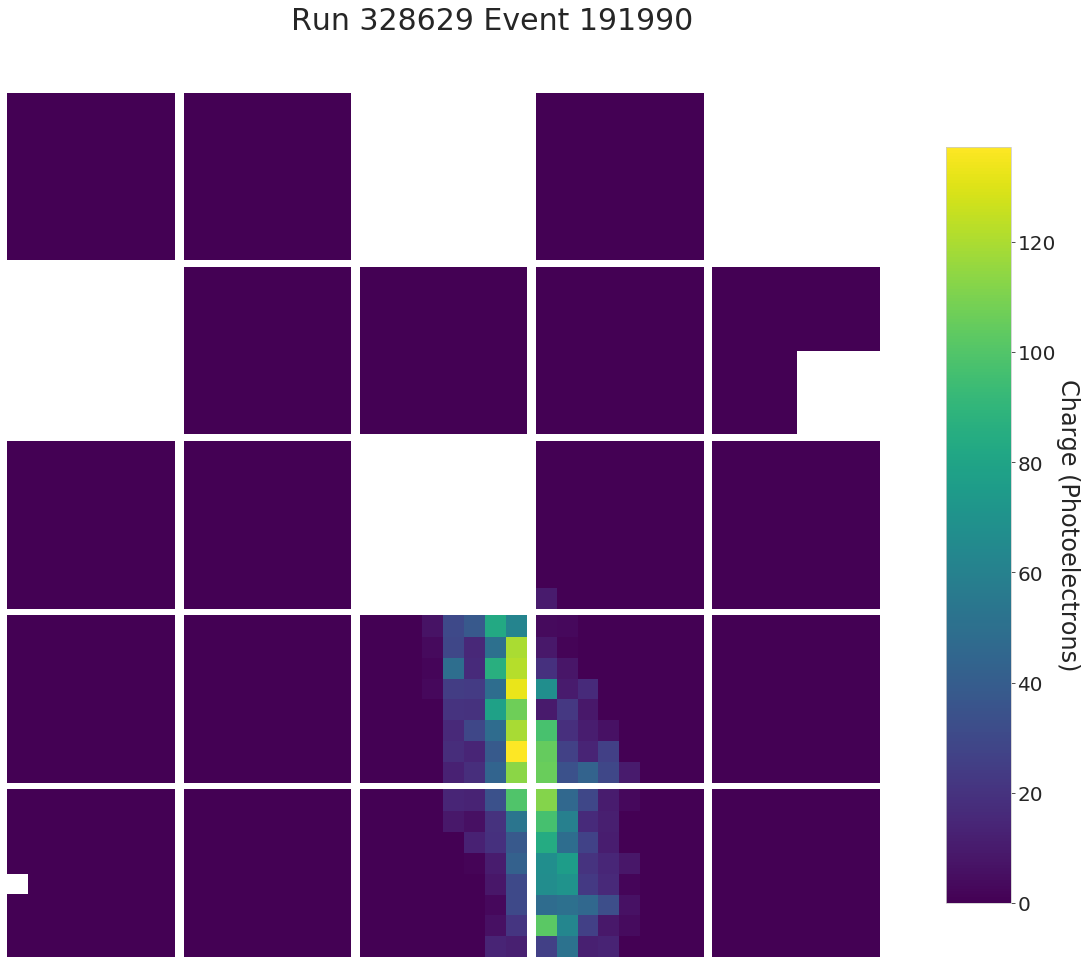

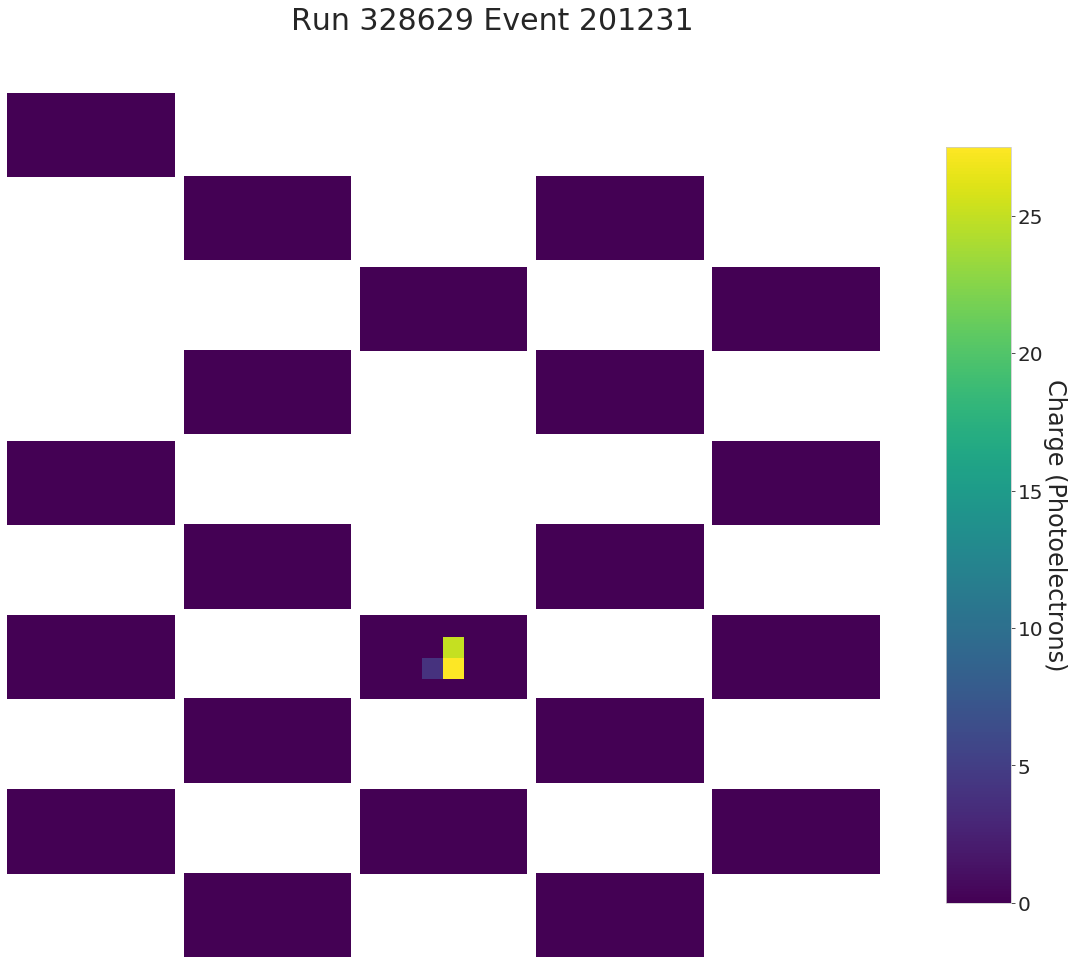

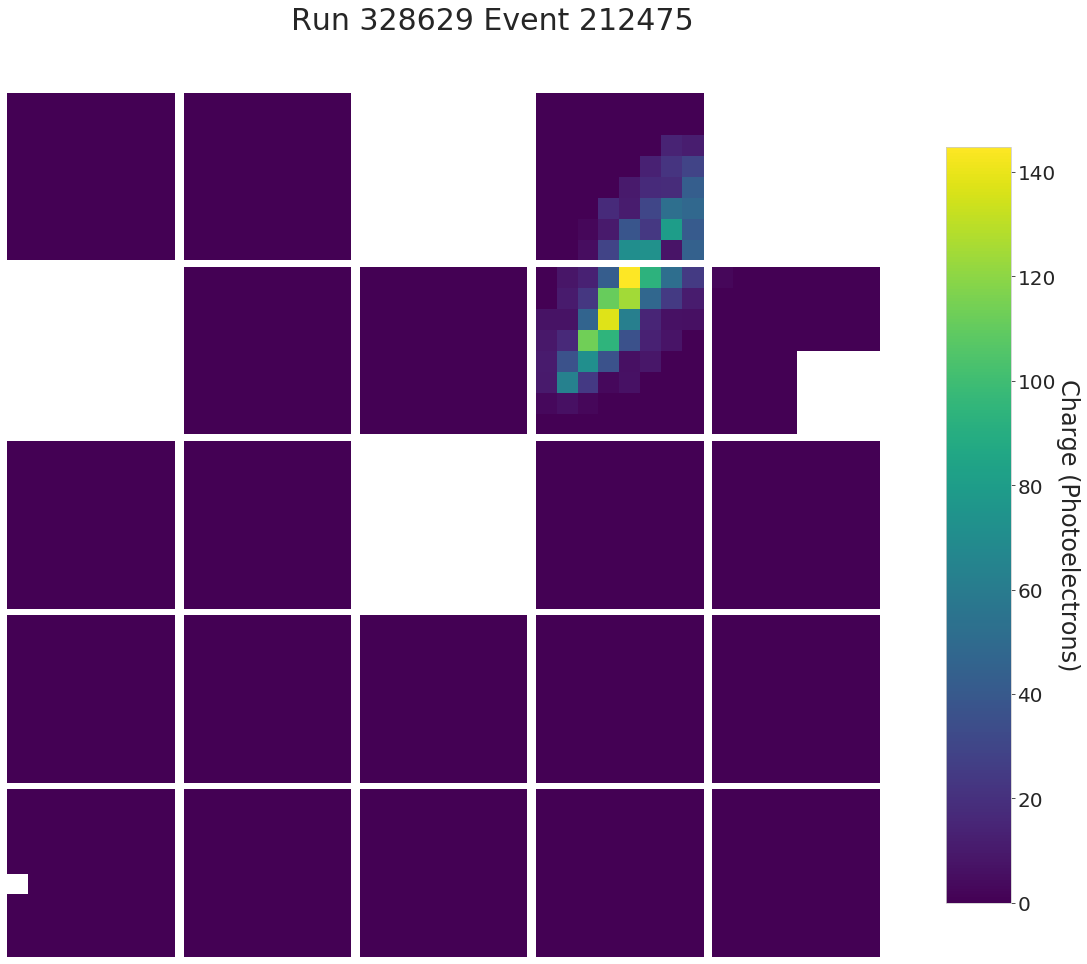

In [39]:
datadir = "/data/wipac/CTA/target5and7data/runs_320000_through_329999"
evdir = "/home/bmode/analysis"
noise_averages = np.load("noise_averages.npz")["arr_0"]
for run in runs:
    if run != 328629:
        continue
    calfile = f"{datadir}/cal{run}.r1"
    cosray_file = f"{evdir}/{run}_cosrays.dat"
    gammas_file = f"{evdir}/{run}_gammas.dat"
    cos_evs = np.loadtxt(cosray_file)
    gamma_evs = np.loadtxt(gammas_file)
    reader = target_io.WaveformArrayReader(calfile)
    n_pixels = reader.fNPixels
    n_samples = reader.fNSamples
    waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
    for ev in gamma_evs[:6]:
        ev = int(ev)
        reader.GetR1Event(ev, waveforms)
        tack = reader.fTACK_time
        peak_positions = np.argmax(waveforms, axis=1)
        charges = mcs.calculate_charge(waveforms, peak_positions, n_samples)
        charges = apply_gains(charges)
        image = clean_image(charges, grid_ind, noise_averages)
        camera_image(image, run, ev)
        plt.show()

In [10]:
for run in runs:
    calfile = f"{datadir}/cal{run}.r1"
    cosray_file = f"{evdir}/{run}_cosrays.dat"
    gammas_file = f"{evdir}/{run}_gammas.dat"
    cos_evs = np.loadtxt(cosray_file)
    gamma_evs = np.loadtxt(gammas_file)
    reader = target_io.WaveformArrayReader(calfile)
    n_pixels = reader.fNPixels
    n_samples = reader.fNSamples
    waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
    for ev in tqdm(gamma_evs):
        ev = int(ev)
        reader.GetR1Event(ev, waveforms)
        tack = reader.fTACK_time
        peak_positions = np.argmax(waveforms, axis=1)
        charges = mcs.calculate_charge(waveforms, peak_positions, n_samples)
        charges = apply_gains(charges)
        image = np.zeros((40, 40))
        for i, val in enumerate(charges):
            image[grid_ind[i] // 40, grid_ind[i] % 40] = val
        camera_image(image, run, ev)

  0%|          | 0/6 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [3]:
cos_width = []
cos_length = []
cos_dis = []
cos_size = []
cos_alpha = []
cos_frac3 = []
gam_width = []
gam_length = []
gam_dis = []
gam_size = []
gam_alpha = []
gam_events = []
gam_frac3 = []
runs = [328629, 328630, 328631]
for run in runs:
    file_ = f"{run}_cosrays_hillas.csv"
    _, _, _, _, _, _, temp_size, temp_frac3, _, _, temp_width, temp_length, _, temp_dis, _, temp_alpha = np.loadtxt(file_, delimiter=", ", skiprows=1, unpack=True)
    cos_width.extend(temp_width)
    cos_length.extend(temp_length)
    cos_dis.extend(temp_dis)
    cos_size.extend(temp_size)
    cos_alpha.extend(temp_alpha)
    cos_frac3.extend(temp_frac3)
for run in runs:
    file_ = f"{run}_gammas_hillas.csv"
    temp_events, _, _, _, _, _, temp_size, temp_frac3, _, _, temp_width, temp_length, _, temp_dis, _, temp_alpha = np.loadtxt(file_, delimiter=", ", skiprows=1, unpack=True)
    gam_width.extend(temp_width)
    gam_length.extend(temp_length)
    gam_dis.extend(temp_dis)
    gam_size.extend(temp_size)
    gam_alpha.extend(temp_alpha)
    gam_events.extend(temp_events)
    gam_frac3.extend(temp_frac3)
    
print(len(cos_width))

10535


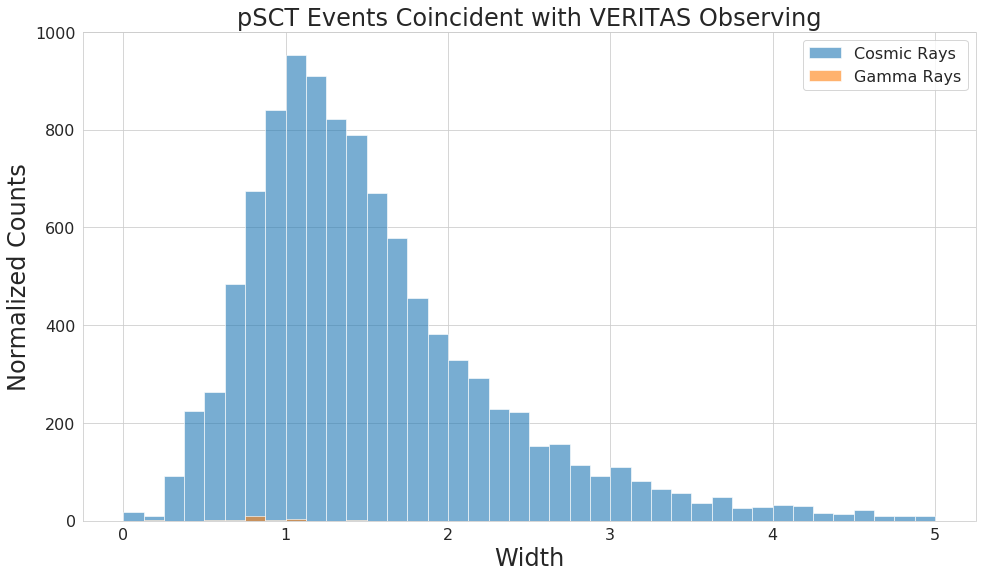

In [8]:
#print(len(failed_events))
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(cos_width, bins=40, range=(0, 5), density=False, alpha=0.6, label="Cosmic Rays")
ax.hist(gam_width, bins=40, range=(0, 5), density=False, alpha=0.6, label="Gamma Rays")
ax.legend(fontsize=16)
ax.set_xlabel("Width", fontsize=24)
ax.set_ylabel("Normalized Counts", fontsize=24)
ax.set_title("pSCT Events Coincident with VERITAS Observing", fontsize=24)
ax.tick_params(labelsize=16)

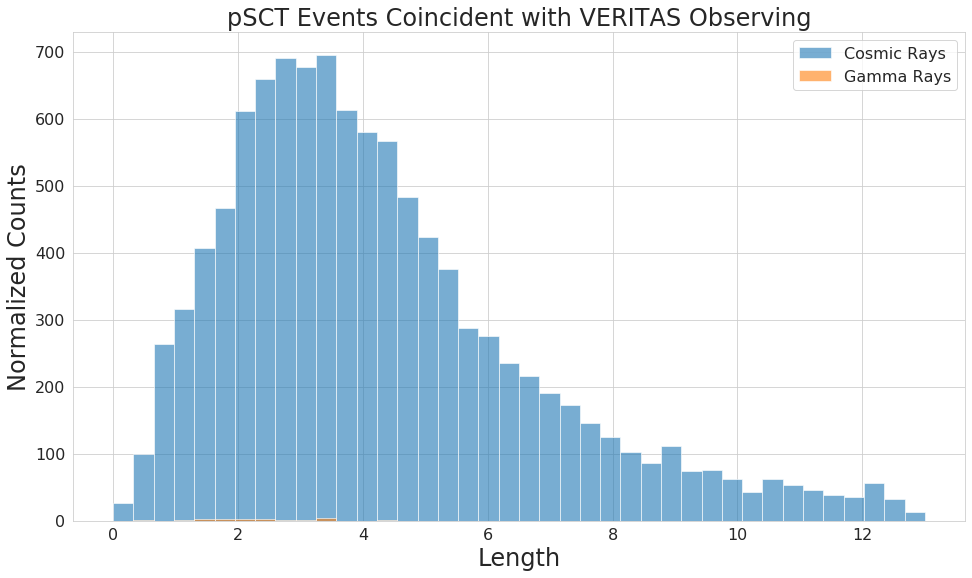

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(cos_length, bins=40, range=(0, 13), density=False, alpha=0.6, label="Cosmic Rays")
ax.hist(gam_length, bins=40, range=(0, 13), density=False, alpha=0.6, label="Gamma Rays")
ax.legend(fontsize=16)
ax.set_xlabel("Length", fontsize=24)
ax.set_ylabel("Normalized Counts", fontsize=24)
ax.set_title("pSCT Events Coincident with VERITAS Observing", fontsize=24)
ax.tick_params(labelsize=16)

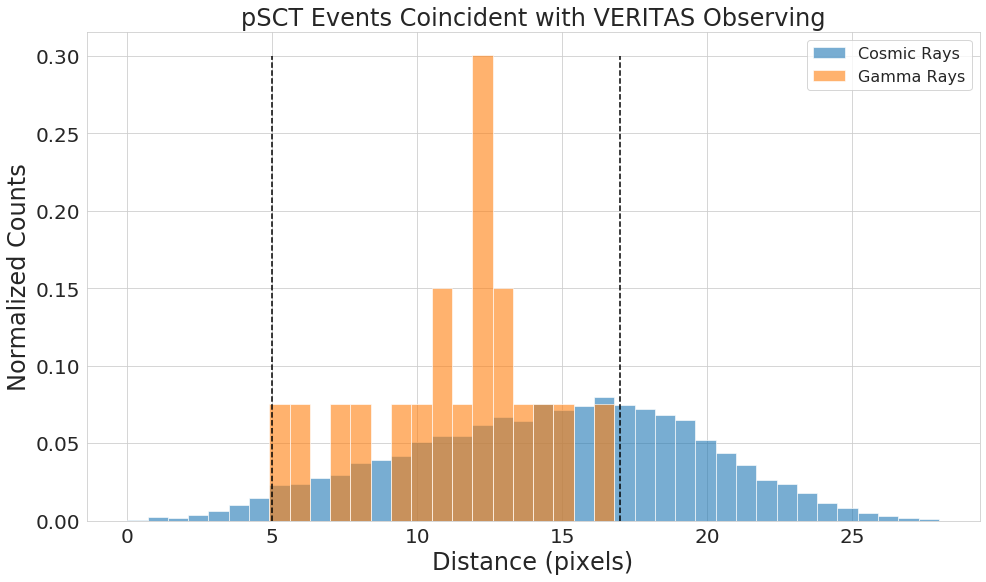

In [4]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(cos_dis, bins=40, density=True, alpha=0.6, label="Cosmic Rays", range=(0, 28))
ax.hist(gam_dis, bins=40, density=True, alpha=0.6, label="Gamma Rays", range=(0, 28))
ax.plot([5, 5], [0, 0.3], color="black", linestyle="--")
ax.plot([17, 17], [0, 0.3], color="black", linestyle="--")
ax.legend(fontsize=16)
ax.set_xlabel("Distance (pixels)", fontsize=24)
ax.set_ylabel("Normalized Counts", fontsize=24)
ax.set_title("pSCT Events Coincident with VERITAS Observing", fontsize=24)
ax.tick_params(labelsize=20)

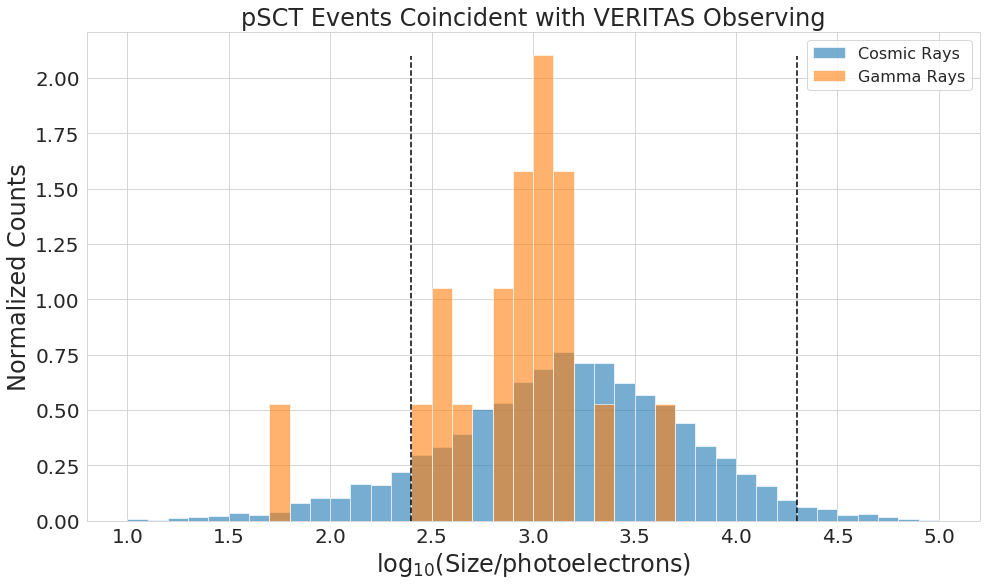

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.log10(np.asarray(cos_size)), bins=40, density=True, alpha=0.6, label="Cosmic Rays", range=(1, 5))
ax.hist(np.log10(np.asarray(gam_size)), bins=40, density=True, alpha=0.6, label="Gamma Rays", range=(1, 5))
ax.plot([np.log10(250), np.log10(250)], [0, 2.1], color="black", linestyle="--")
ax.plot([np.log10(20000), np.log10(20000)], [0, 2.1], color="black", linestyle="--")
ax.legend(fontsize=16)
ax.set_xlabel(r"$\log_{10}$(Size/photoelectrons)", fontsize=24)
ax.set_ylabel("Normalized Counts", fontsize=24)
ax.set_title("pSCT Events Coincident with VERITAS Observing", fontsize=24)
ax.tick_params(labelsize=20)

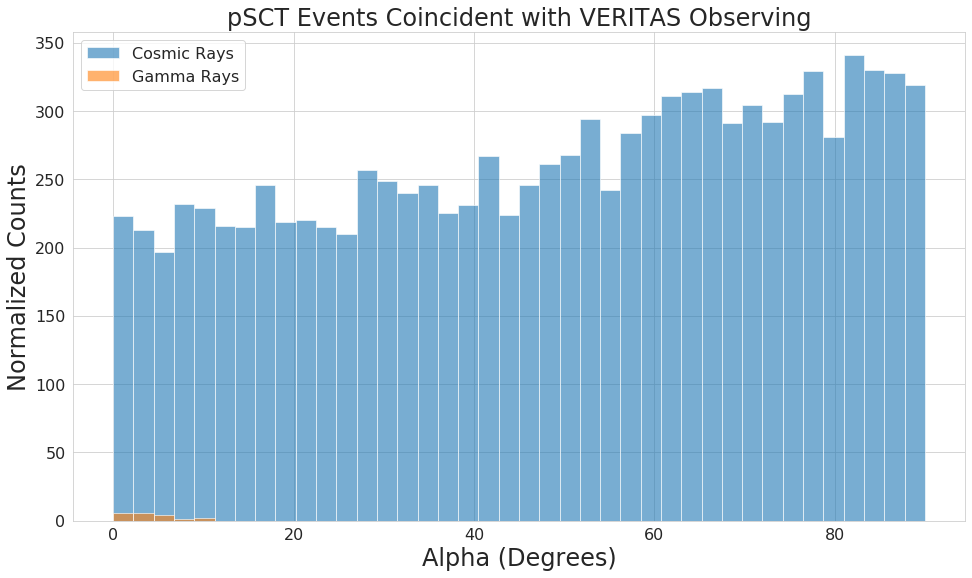

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.degrees(cos_alpha), bins=40, density=False, alpha=0.6, label="Cosmic Rays", range=(0, 90))
ax.hist(np.degrees(gam_alpha), bins=40, density=False, alpha=0.6, label="Gamma Rays", range=(0, 90))
ax.legend(fontsize=16)
ax.set_xlabel("Alpha (Degrees)", fontsize=24)
ax.set_ylabel("Normalized Counts", fontsize=24)
ax.set_title("pSCT Events Coincident with VERITAS Observing", fontsize=24)
ax.tick_params(labelsize=16)

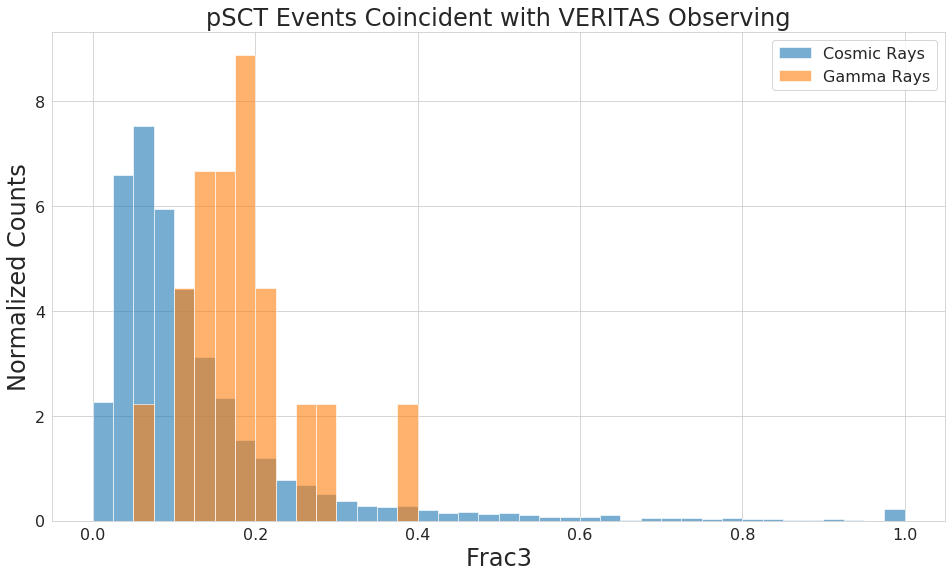

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(cos_frac3, bins=40, density=True, alpha=0.6, label="Cosmic Rays", range=(0, 1.0))
ax.hist(gam_frac3, bins=40, density=True, alpha=0.6, label="Gamma Rays", range=(0, 1.0))
ax.legend(fontsize=16)
ax.set_xlabel("Frac3", fontsize=24)
ax.set_ylabel("Normalized Counts", fontsize=24)
ax.set_title("pSCT Events Coincident with VERITAS Observing", fontsize=24)
ax.tick_params(labelsize=16)

0.10232558139534884
Cosmic Rays: 1078
Gamma Rays: 18


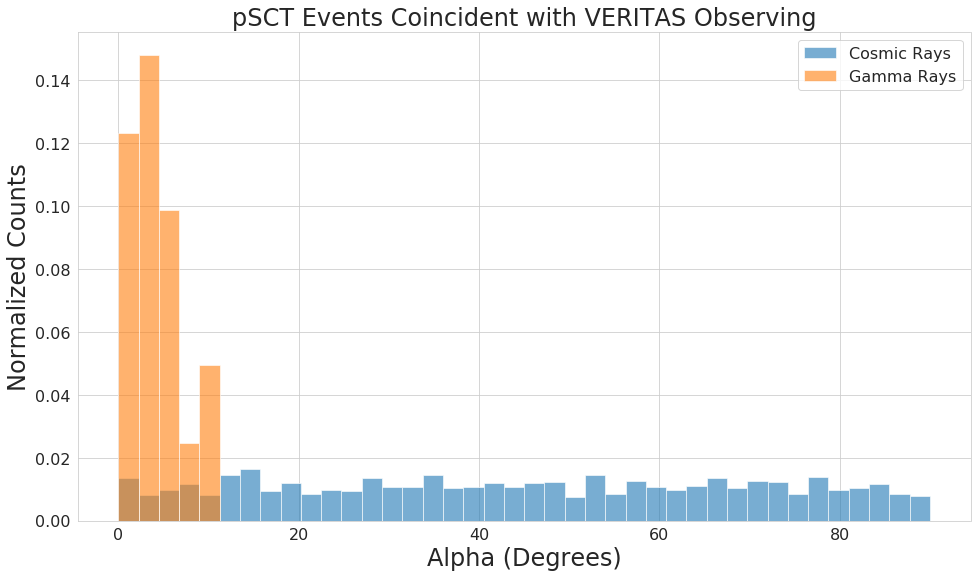

In [22]:
first_cut_cosrays = [i for i, val in enumerate(cos_width) if val < -0.95+0.7*np.log10(cos_size[i]) and cos_length[i] < -5.3+3.0*np.log10(cos_size[i]) and cos_size[i] > 250 and cos_dis[i] < 17]
first_cut_gammas = [i for i, val in enumerate(gam_width) if val < -0.95+0.7*np.log10(gam_size[i]) and gam_length[i] < -5.3+3.0*np.log10(gam_size[i]) and gam_size[i] > 250 and gam_dis[i] < 17]
cos_alpha = np.asarray(cos_alpha)
gam_alpha = np.asarray(gam_alpha)
print(len(first_cut_cosrays) / len(cos_alpha))
print(f"Cosmic Rays: {len(first_cut_cosrays)}")
print(f"Gamma Rays: {len(first_cut_gammas)}")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.degrees(cos_alpha[first_cut_cosrays]), bins=40, density=True, alpha=0.6, label="Cosmic Rays", range=(0, 90))
ax.hist(np.degrees(gam_alpha[first_cut_gammas]), bins=40, density=True, alpha=0.6, label="Gamma Rays", range=(0, 90))
ax.legend(fontsize=16)
ax.set_xlabel("Alpha (Degrees)", fontsize=24)
ax.set_ylabel("Normalized Counts", fontsize=24)
ax.set_title("pSCT Events Coincident with VERITAS Observing", fontsize=24)
ax.tick_params(labelsize=16)

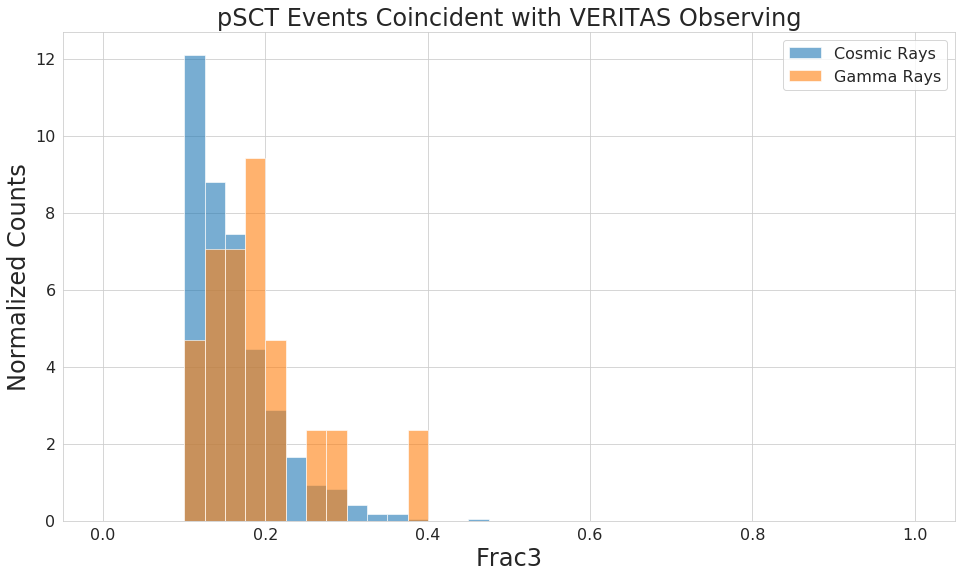

In [16]:
cos_frac3 = np.asarray(cos_frac3)
gam_frac3 = np.asarray(gam_frac3)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(cos_frac3[first_cut_cosrays], bins=40, density=True, alpha=0.6, label="Cosmic Rays", range=(0, 1.0))
ax.hist(gam_frac3[first_cut_gammas], bins=40, density=True, alpha=0.6, label="Gamma Rays", range=(0, 1.0))
ax.legend(fontsize=16)
ax.set_xlabel("Frac3", fontsize=24)
ax.set_ylabel("Normalized Counts", fontsize=24)
ax.set_title("pSCT Events Coincident with VERITAS Observing", fontsize=24)
ax.tick_params(labelsize=16)

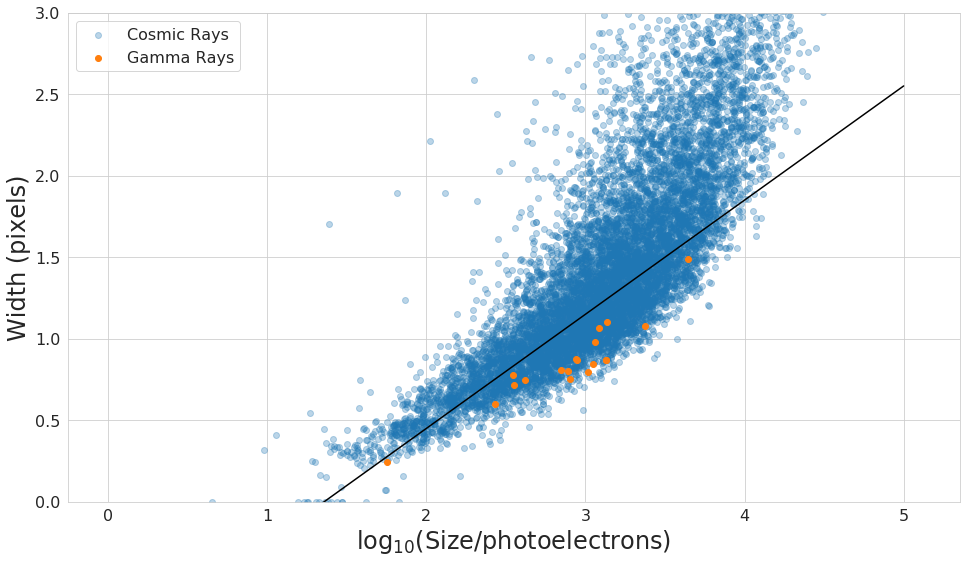

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
x = np.logspace(0, 5, 1000)
ax.scatter(np.log10(cos_size), cos_width, alpha=0.3, label="Cosmic Rays")
ax.scatter(np.log10(gam_size), gam_width, label="Gamma Rays")
ax.plot(np.log10(x), -0.95+0.7*np.log10(x), color="black")
ax.set_ylim((0, 3))
ax.set_xlabel(r"$\log_{10}$(Size/photoelectrons)", fontsize=24)
ax.set_ylabel("Width (pixels)", fontsize=24)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc="upper left")

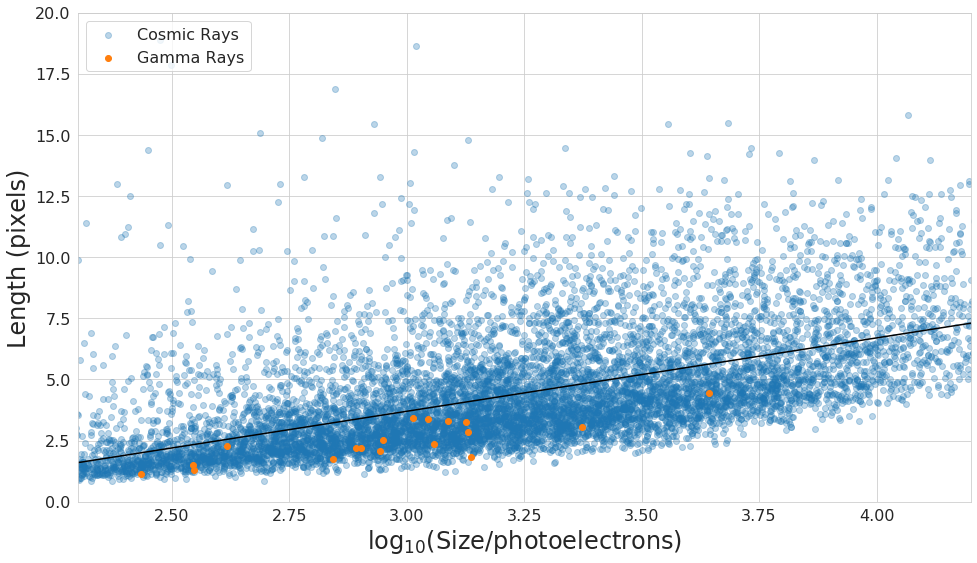

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

ax.scatter(np.log10(cos_size), cos_length, alpha=0.3, label="Cosmic Rays")
ax.scatter(np.log10(gam_size), gam_length, label="Gamma Rays")
ax.plot(np.log10(x), -5.3+3.0*np.log10(x), color="black")
ax.set_ylim((0, 20))
ax.set_xlim((2.3, 4.2))
ax.set_xlabel(r"$\log_{10}$(Size/photoelectrons)", fontsize=24)
ax.set_ylabel("Length (pixels)", fontsize=24)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc="upper left")

In [7]:
file_ = "/data/user/bmode/crab_data/on_data_run328629_test.txt"
_, events, cpu_s, cpu_ns, tack, size, \
frac2, x, y, width, length, _, dis, azwidth, alpha = np.loadtxt(file_, unpack=True, skiprows=1, delimiter=", ")

In [8]:
print(len(events))

4810


In [23]:
first_cut = [i for i, val in enumerate(width) if val < -0.95+0.7*np.log10(size[i]) 
             and length[i] < -5.3+3.0*np.log10(size[i]) 
             and size[i] > 250 
             and dis[i] < 17]
print(len(first_cut))
print(len(first_cut) / len(events))
matched_gammas = [ev for ev in events if ev in gam_events]
print(len(matched_gammas))
print(matched_gammas)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.degrees(alpha), bins=40, density=False, alpha=0.6, range=(0, 90))
#ax.legend(fontsize=16)
ax.set_xlabel("Alpha (Degrees)", fontsize=24)
ax.set_ylabel("Normalized Counts", fontsize=24)
ax.set_title("First Cut Attempt - Run 328629", fontsize=24)
ax.tick_params(labelsize=16)

TypeError: 'float' object is not iterable

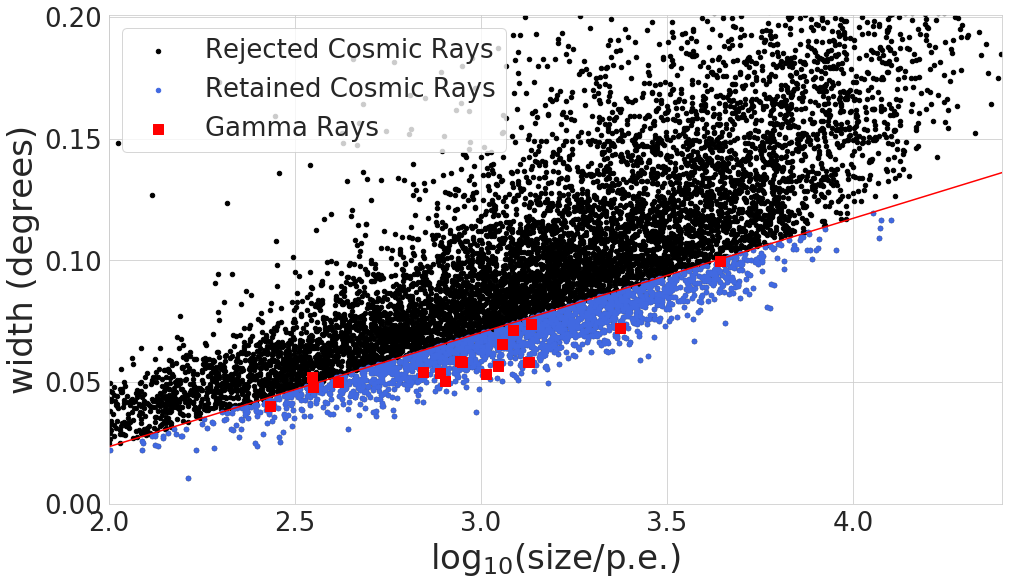

In [8]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
x = np.logspace(0, 5, 1000)
temp = [i for i, val in enumerate(cos_width) if val < -1.05+0.7*np.log10(cos_size[i])]
ax.scatter(np.log10(cos_size), np.asarray(cos_width)*0.067, color="black", s=20, alpha=1, label="Rejected Cosmic Rays")
ax.scatter(np.log10(cos_size)[temp], np.asarray(cos_width)[temp]*0.067, color="royalblue", s=20, alpha=1, label="Retained Cosmic Rays")
ax.scatter(np.log10(gam_size), np.asarray(gam_width)*0.067, marker="s", color="red", label="Gamma Rays", s=100)
ax.plot(np.log10(x), -1.05*0.067+0.7*0.067*np.log10(x), color="red")
ax.set_ylim((0, 3*0.067))
ax.set_xlim((2, 4.4))
ax.set_xlabel(r"$\log_{10}$(size/p.e.)", fontsize=34)
ax.set_ylabel("width (degrees)", fontsize=34)
ax.tick_params(labelsize=26)
ax.legend(fontsize=26, loc="upper left")
plt.locator_params(axis="y", nbins=5)
fig.savefig("crab_width_size_new.pdf")

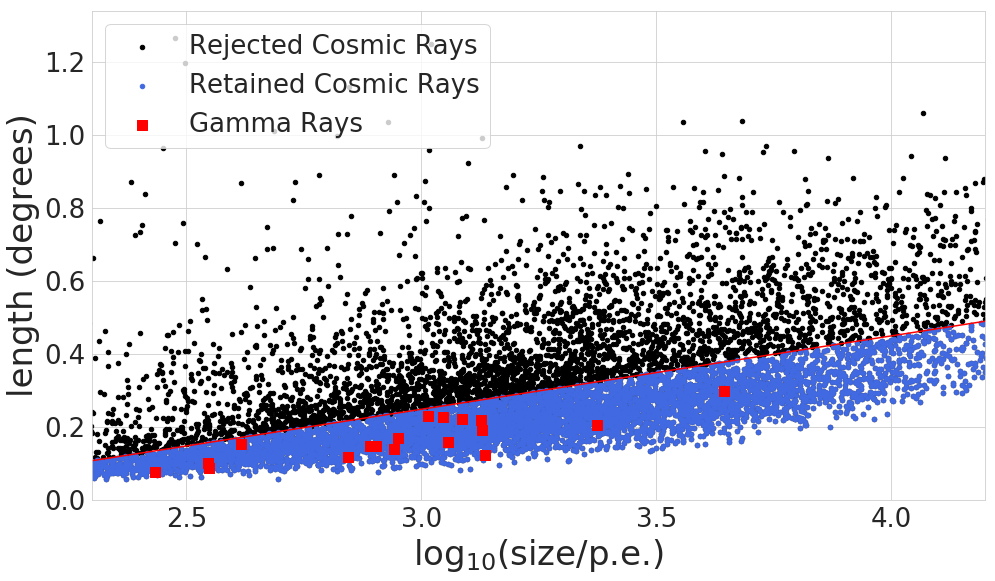

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
temp = [i for i, val in enumerate(cos_length) if val < -5.3+3.0*np.log10(cos_size[i])]
ax.scatter(np.log10(cos_size), np.asarray(cos_length)*0.067, s=20, color="black", label="Rejected Cosmic Rays")
ax.scatter(np.log10(cos_size)[temp], np.asarray(cos_length)[temp]*0.067, color="royalblue", s=20, label="Retained Cosmic Rays")
ax.scatter(np.log10(gam_size), np.asarray(gam_length)*0.067, label="Gamma Rays", color="red", marker="s", s=100)
ax.plot(np.log10(x), -5.3*0.067+3.0*0.067*np.log10(x), color="red")
ax.set_ylim((0, 0.067*20))
ax.set_xlim((2.3, 4.2))
ax.set_xlabel(r"$\log_{10}$(size/p.e.)", fontsize=34)
ax.set_ylabel("length (degrees)", fontsize=34)
ax.tick_params(labelsize=26)
ax.legend(fontsize=26, loc="upper left")
plt.locator_params(axis="x", nbins=4)
fig.savefig("crab_length_size_new.pdf")